# **Iris Clustering Using KMeans, Hierarchical & DBSCAN**
## Developed By : **Md. Shoaib Ahmed**

## Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix

from sklearn.datasets import load_iris
from sklearn.neighbors import NearestNeighbors

## Loading Dataset

In [ ]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df['species'] = iris.target

print("Dataset Loaded with shape:", df.shape)
df.head()

Dataset Loaded with shape: (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Data Preprocessing

In [ ]:
#Check missing values
print("Missing values:\n", df.isnull().sum())

# Outlier Detection using Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df.iloc[:, :-1])
df['Outlier'] = outliers
# Keeping inliers only
df = df[df['Outlier'] == 1].drop(columns='Outlier')
print("\nOutliers are removed! \nNew shape:", df.shape)

#Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('species', axis=1))

Missing values:
 sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Outliers are removed! 
New shape: (142, 5)


## Exploratory Data Analysis (EDA)

1. Pairplot

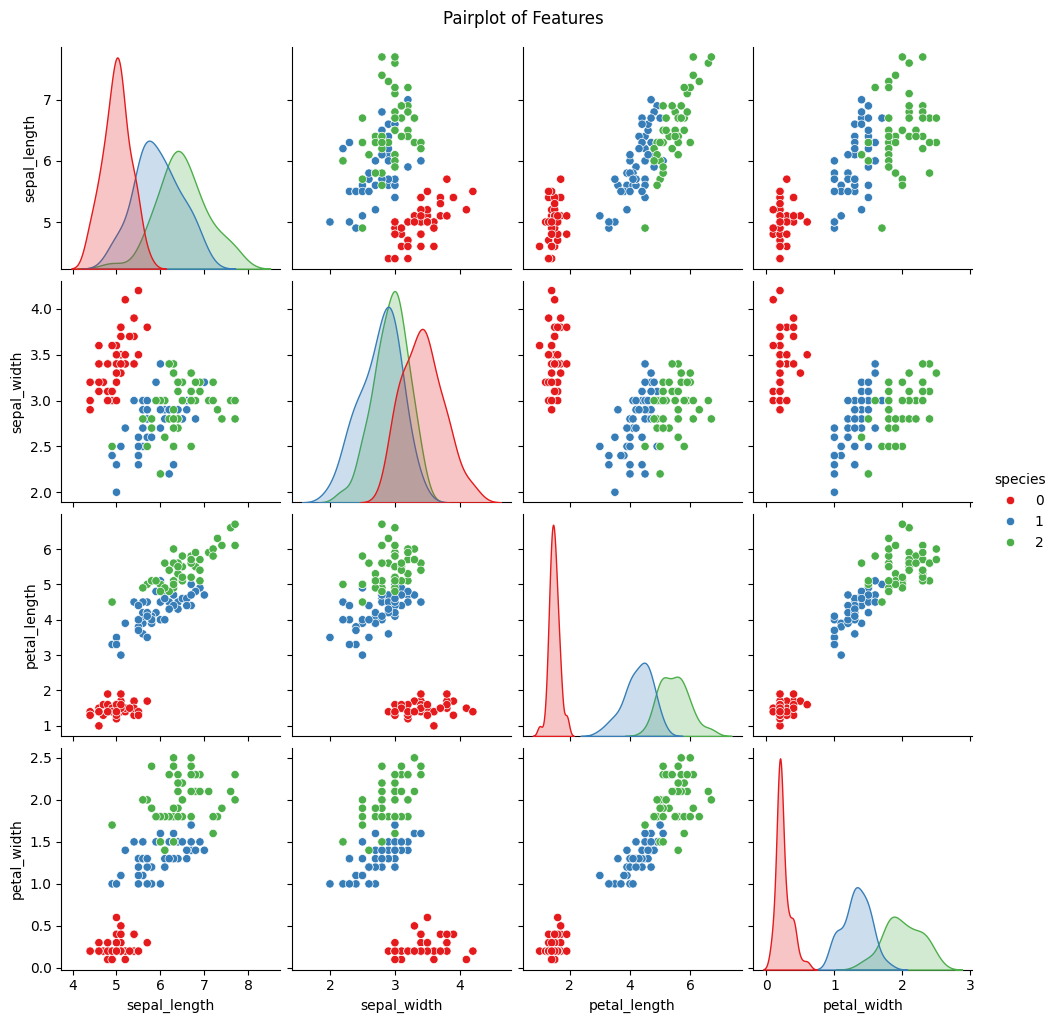

In [ ]:
sns.pairplot(df, hue='species', palette='Set1')
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

2. Correlation Heatmap

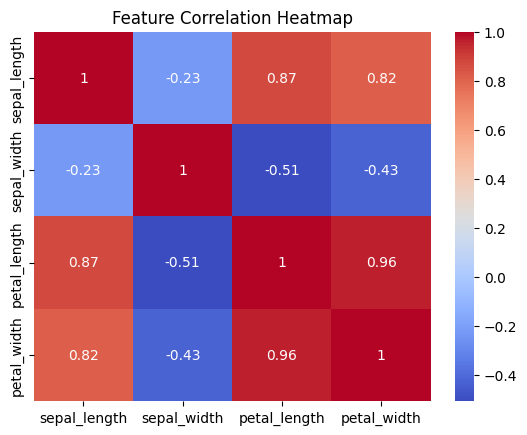

In [ ]:
sns.heatmap(df.drop('species', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

3. Feature Distribution per Species

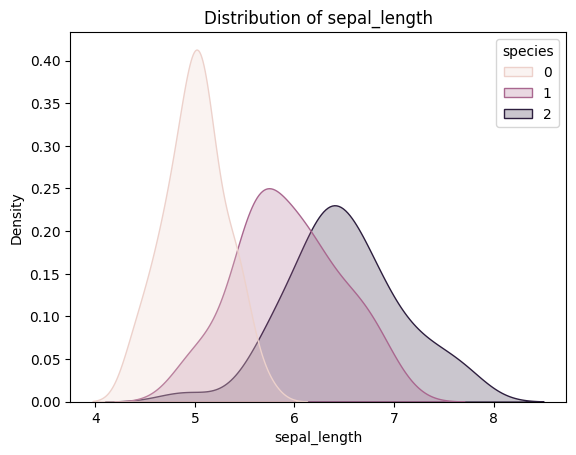

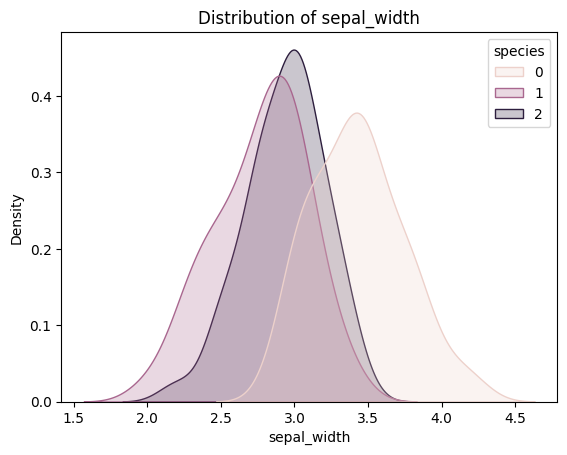

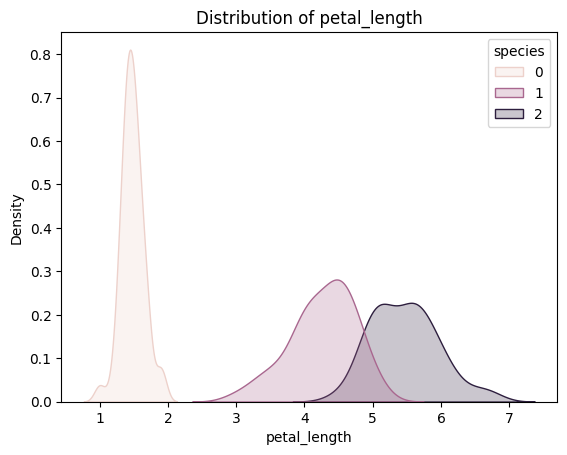

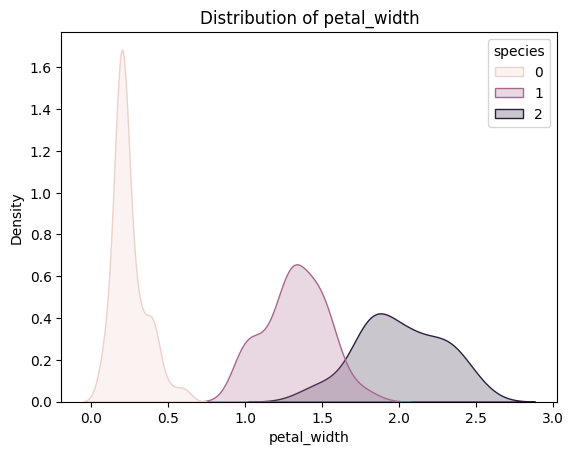

In [ ]:
for col in df.columns[:-1]:
    sns.kdeplot(data=df, x=col, hue='species', fill=True)
    plt.title(f'Distribution of {col}')
    plt.show()

## Dimensionality Reduction (PCA & t-SNE)

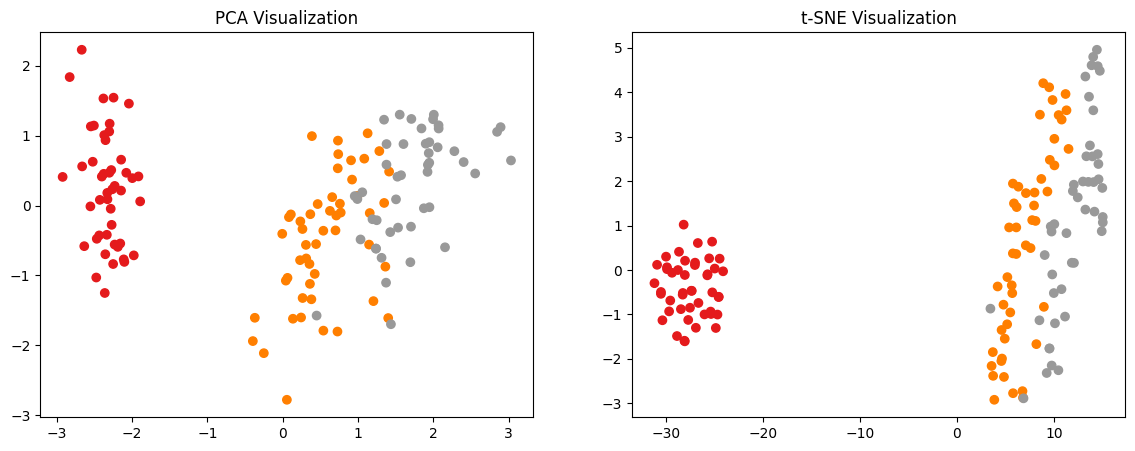

In [ ]:
# PCA(2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE(2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize PCA and t-SNE
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=df['species'], cmap='Set1')
axs[0].set_title('PCA Visualization')

axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['species'], cmap='Set1')
axs[1].set_title('t-SNE Visualization')
plt.show()

## KMeans Clustering

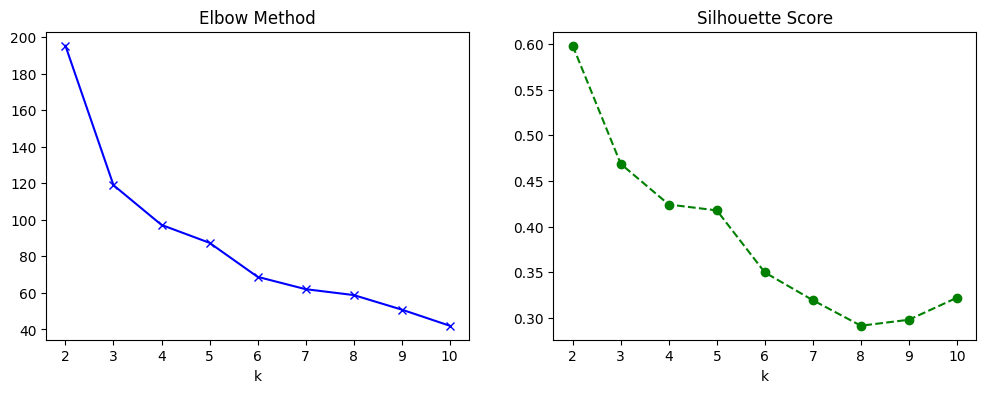

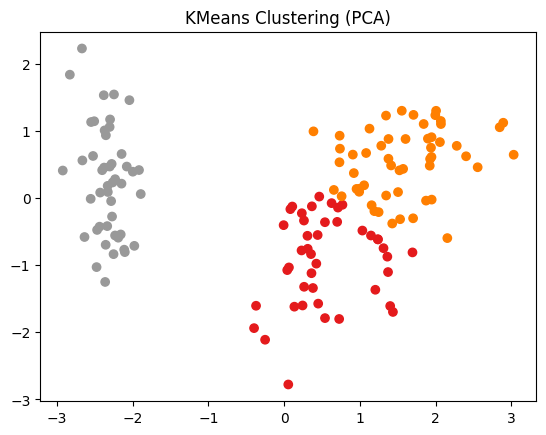

In [ ]:
# Elbow Method
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow and Silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')

ax[1].plot(K, silhouette, 'go--')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('k')
plt.show()

# Apply KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Visualize
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='Set1')
plt.title('KMeans Clustering (PCA)')
plt.show()

## Hierarchical Clustering

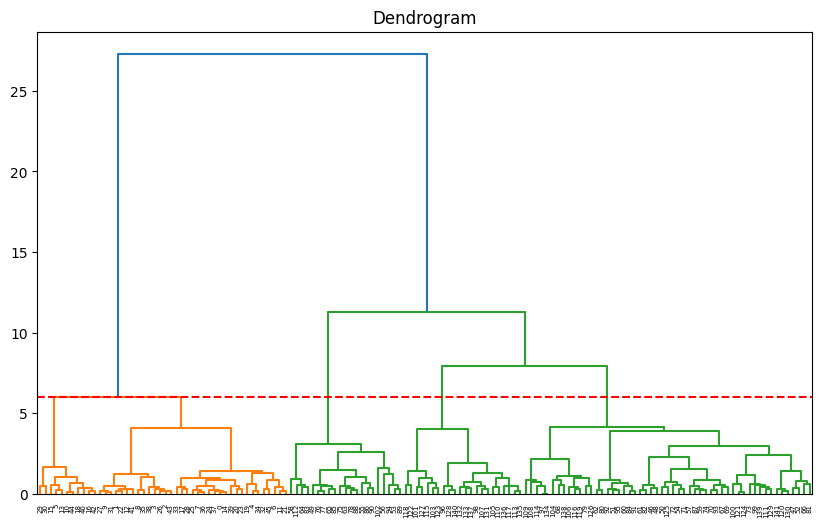

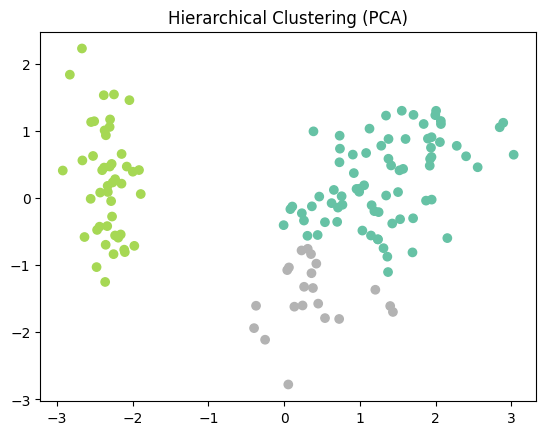

In [ ]:
# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage(X_scaled, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')  # Threshold line
plt.title("Dendrogram")
plt.show()

# Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_scaled)

# Visualization
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='Set2')
plt.title("Hierarchical Clustering (PCA)")
plt.show()

In [ ]:
# Silhouette
print("Silhouette Score (Hierarchical):", silhouette_score(X_scaled, agg_labels))

Silhouette Score (Hierarchical): 0.46532589647073835


## DBSCAN Clustering

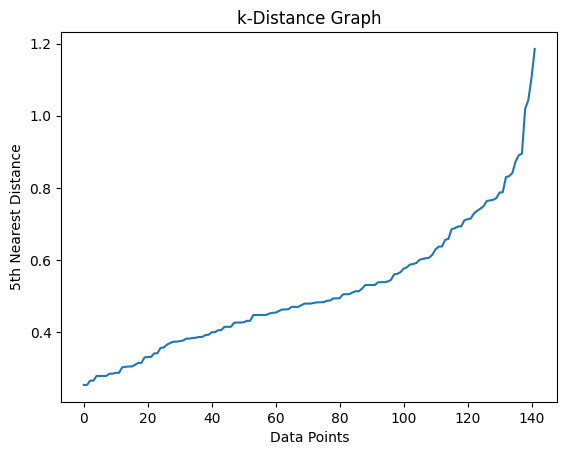

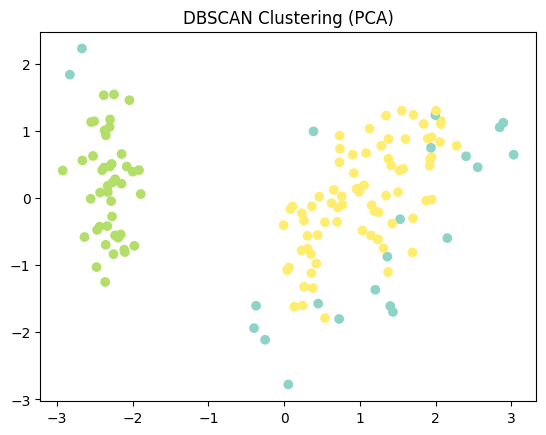

In [ ]:
# k-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.title("k-Distance Graph")
plt.xlabel("Data Points")
plt.ylabel("5th Nearest Distance")
plt.show()

# Apply DBSCAN
db = DBSCAN(eps=0.6, min_samples=5)
db_labels = db.fit_predict(X_scaled)

# Visualization
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, cmap='Set3')
plt.title("DBSCAN Clustering (PCA)")
plt.show()

## Evaluation & Comparison


KMeans
ARI Score: 0.6208354961702137




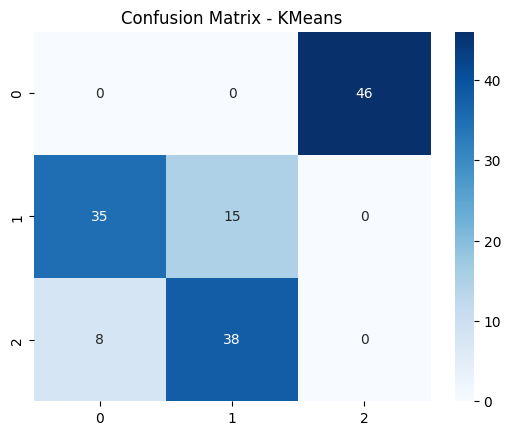


Hierarchical
ARI Score: 0.5546969730521828




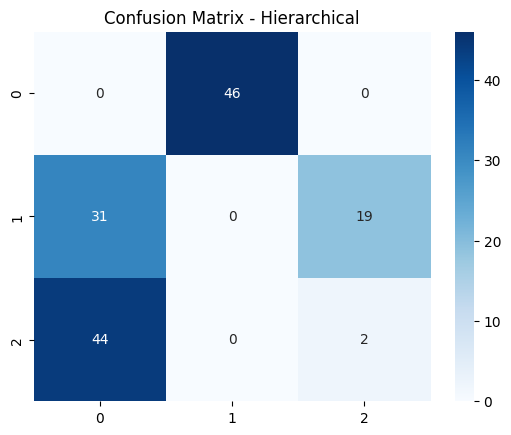


DBSCAN
ARI Score: 0.48277961889725063




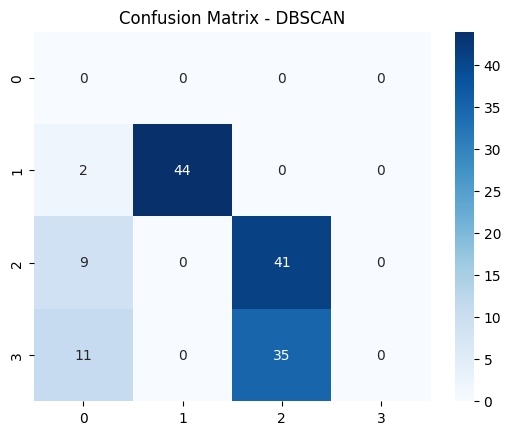

In [ ]:
def evaluate_clustering(true_labels, pred_labels, method_name):
    print(f"\n{method_name}")
    print("ARI Score:", adjusted_rand_score(true_labels, pred_labels))
    print("\n")
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {method_name}')
    plt.show()

evaluate_clustering(df['species'], kmeans_labels, "KMeans")
evaluate_clustering(df['species'], agg_labels, "Hierarchical")
evaluate_clustering(df['species'], db_labels, "DBSCAN")

## Final Comparison Table & Insights

In [ ]:
comparison = pd.DataFrame({
    'Algorithm': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'ARI Score': [
        adjusted_rand_score(df['species'], kmeans_labels),
        adjusted_rand_score(df['species'], agg_labels),
        adjusted_rand_score(df['species'], db_labels)
    ]
})

comparison = comparison.sort_values(by='ARI Score', ascending=False)
print("Clustering Algorithm Comparison:\n")
print(comparison.to_string(index=False))

# Final Insight
from IPython.display import Markdown
Markdown("""
### Final Observations:

- ARI Score Comparison: (Best to Worst): **KMeans** > **Hierarchical** > **DBSCAN**
- **KMeans** performed best based on ARI score.
- **DBSCAN** was sensitive to parameters and identified noise or outliers well.
- **PCA and t-SNE** helped visualize separation between clusters.
- Using **Isolation Forest** for outlier removal improved overall clustering stability.
""")

Clustering Algorithm Comparison:

   Algorithm  ARI Score
      KMeans   0.620835
Hierarchical   0.554697
      DBSCAN   0.482780



### Final Observations:

- ARI Score Comparison: (Best to Worst): **KMeans** > **Hierarchical** > **DBSCAN**
- **KMeans** performed best based on ARI score.
- **DBSCAN** was sensitive to parameters and identified noise or outliers well.
- **PCA and t-SNE** helped visualize separation between clusters.
- Using **Isolation Forest** for outlier removal improved overall clustering stability.
